# Correlated features and asymptotic risk curve

In [1]:
from sklearn.base import RegressorMixin
from scipy.optimize import fsolve   # solve for the function

import numpy as np
import seaborn as sns

from scipy.stats import ortho_group # othogonal matrix

import os
import json, codecs

import matplotlib.pyplot as plt

import scienceplots
import matplotlib.pyplot as plt 

# Sketched estimator and ridgeless estimator

In [2]:
from scipy.fftpack import dct
import numpy as np

def generate_harr_matrix(n, p):
    if n <= p:
        return np.linalg.qr(np.random.randn(p,n))[0].T
    else:
        return np.linalg.qr(np.random.randn(p,n))[0]

def hadamard_projection(X, r):
    n, p = X.shape
    X_tilde = np.concatenate([X, np.zeros((n, 1))], axis=1)
    X[: int(n / 2), :] = -X[: int(n/2), :]
    np.random.shuffle(X)
    X_tilde_dct = dct(X, axis=0, norm='ortho')
    #X_tilde_dct[0, :] = X_tilde_dct[0:, ] / np.sqrt(n)
    idx_sample = np.random.choice(n, r, replace=False)
    X_tilde_sampled = X_tilde_dct[idx_sample, :p]

    return X_tilde_sampled

def generate_orthogonal_matrix(n):
    X = generate_harr_matrix(n, n)
    S = hadamard_projection(X, n)
    return S

In [2]:
class RidgelessLinearRegressor(RegressorMixin):
    """Ridgeless linear regression using Moore Penrose pseudoinverse."""

    def __init__(self):
        self.beta = None

    def fit(self, x, y):
        n = x.shape[0]
        p = x.shape[1]
        
        #xxinv = np.linalg.pinv(np.matmul(x.T, x))
        #xy = np.matmul(x.T, y)
        
        Ip = np.eye(p)
        xxinv = np.linalg.inv(np.matmul(x.T, x)/n + 1e-9 * Ip)
        xy = np.matmul(x.T, y)/n
        
        self.beta = np.matmul(xxinv, xy)
        return self

    def predict(self, x):
        return np.matmul(x, self.beta)

In [3]:
class SketchedRidgelessRegressor(RegressorMixin):
    """Sketched Ridgeless regression using Moore Penrose pseudoinverse."""

    def __init__(self):
        self.beta = None

    def fit(self, x, y, m, is_orthogonal=True):
        n = x.shape[0]
        p = x.shape[1]

        if is_orthogonal:
            S = generate_orthogonal_matrix(n)[0:m, :]
            #S = ortho_group.rvs(dim=n)[0:m, :]   # orthogonal schetching matrix
        else:
            S = np.random.normal(size=(m, n), scale=1/np.sqrt(n))    # schetching matrix

        sx = np.matmul(S, x)
        sy = np.matmul(S, y)

        # xxinv = np.linalg.pinv(np.matmul(sx.T, sx))
        # xy = np.matmul(sx.T, sy)
        
        Ip = np.eye(p)
        xxinv = np.linalg.inv(np.matmul(sx.T, sx)/n + 1e-9 * Ip)
        xy = np.matmul(sx.T, sy)/n
        
        self.beta = np.matmul(xxinv, xy)
        return self

    def predict(self, x):
        return np.matmul(x, self.beta)

# Data generation

- Assumption 2.2, $\beta \sim \mathcal{N}_p\left(0, \frac{\alpha^2}{p} I_p\right)$, where $||\beta||^2_2 \to \alpha^2$, independent of the data matrix $X$, noise $\epsilon$, sketching matrix $S$.
- Assumption $2.4$ (Correlated features). $\Sigma$ is a deterministic positive definite matrix, and there exists constants $C_0, C_1$ satisfying $0<C_0 \leq \lambda_{\min }(\Sigma) \leq \lambda_{\min }(\Sigma) \leq C_1$ for all $n, p$. Define the empirical spectral distribution (ESD) of $\Sigma$ as $F^{\Sigma}(x)=\frac{1}{p} \sum_{i=1}^p \mathbb{1}\left\{\lambda_i(\Sigma) \leq x\right\}$. Assume that as $p \rightarrow \infty$, the ESD $F^{\Sigma}$ converges weakly to a probability measure $H$.


In [4]:
def fn(c, x, phi, psi):
    sum_ = [i/(-c + i * psi / phi) for i in x]
    return np.mean(sum_) - 1

def unique_c0_op(lambda1, phi, psi, init=-4):
    c0 = fsolve(fn, args=(lambda1, phi, psi), x0=init)
    if fn(c0, lambda1, phi, psi) < 1e-7:
        return c0
    else:
        print("Specify another starting point for the optimization method")

In [5]:
def gn(c, x, phi, psi):
    sum_ = [i/(-c + i * phi) for i in x]
    return np.mean(sum_) - 1/psi

def unique_c0_up(lambda1, phi, psi, init=4):
    c0 = fsolve(gn, args=(lambda1, phi, psi), x0=init)
    if gn(c0, lambda1, phi, psi) < 1e-7:
        return c0
    else:
        print("Specify another starting point for the optimization method")

In [28]:
def asy_risk_sketching(n, p, m, alpha, is_orthogonal, lambda_op, sigma=1):
    """
    gamma: p/n
    psi: m/n
    norm: alpha in Lemma 3.2
    """

    phi = p / n
    psi = m / n
    
    condition = phi / psi
    condition_inv = psi / phi

    c0_op = unique_c0_op(lambda_op, phi, psi, init=-1)[0]
    #c0_up = unique_c0_up(lambda_up, phi, psi, init=-1)[0] # Orthogonal s

    if m > p and condition_inv > 1: 
        b_up = 0
        # numerator_ = psi * np.mean([i**2 * phi / (c0_up - i * phi)**2 for i in lambda_up])
        # denominator_ = 1 - psi * np.mean([i**2 * phi / (c0_up - i * phi)**2 for i in lambda_up])
        # v_up = sigma**2 * numerator_ / denominator_
        
        if is_orthogonal:
            v_up = sigma**2 * (condition / (1-condition))
        else:
            v_up = sigma**2 * (phi/(1-phi) + condition / (1-condition))
        return b_up + v_up

    if m < p and condition > 1:
        b_op = -alpha**2 * c0_op
        numerator_ = np.mean([i**2 * condition_inv / (c0_op - i * condition_inv)**2 for i in lambda_op])
        denominator_ = 1 - np.mean([i**2 * condition_inv / (c0_op - i * condition_inv)**2 for i in lambda_op])
        v_op = sigma**2 * numerator_ / denominator_
        return b_op + v_op

## Simulation

In [7]:
def gen_train_dat(n_train, n_features, alpha, x_sigma, sigma):
    """
    n_samples: n
    n_features: p
    alpha: beta's norm
    sigma: sigma
    """

    #bet = norm / np.sqrt(p) * np.ones(p) 

    # Assumption 2.2 (random beta)
    bet = alpha / np.sqrt(n_features) * np.random.normal(size=n_features)  #from guassian prior

    # Assumption 2.4 (correlated features)
    x = np.random.multivariate_normal(mean=np.zeros(n_features), cov=x_sigma, size=(n_train))
    eps = np.random.normal(size=n_train, scale=sigma)
    y = np.matmul(x, bet.T) + eps

    return x, y, bet

def gen_test_dat(n_test, n_features, beta, x_sigma, sigma):
    x = np.random.multivariate_normal(mean=np.zeros(n_features), cov=x_sigma, size=(n_test))
    eps = np.random.normal(size=n_test, scale=sigma)
    y = np.matmul(x, beta) + eps

    return x, y

In [8]:
def simulate_sketching(n_train, n_features, m, alpha, sigma, x_sigma, seed, is_orthogonal=True, n_test=1):
    np.random.seed(seed)
    
    # train
    x, y, beta = gen_train_dat(n_train, n_features, alpha, x_sigma, sigma)  

    # test
    x_oos, y_oos = gen_test_dat(n_test, n_features, beta, x_sigma, sigma)

    # fit ridgeless least square using sketching matrix
    ridgeless = SketchedRidgelessRegressor()
    ridgeless = ridgeless.fit(x, y, m, is_orthogonal)
    
    # calculate mse
    test_mse = np.mean((np.matmul(x_oos, ridgeless.beta) - np.matmul(x_oos, beta))**2)

    return test_mse 

In [9]:
n_train = 400
n_features = 200
n_test = 100

alpha = 9
sigma = 3
seed = 12341
n_sim = 500

n_pts = 20                 # number of points in the graph for visualizing empirical results (dots)
n_pts_asymp = 50          # number of points in the graph for visualizing theorem 3.2 (line)

In [10]:
from joblib import Parallel, delayed

## Orthogonal sketching matrix

In [49]:
%%time
m = np.zeros(n_pts, dtype=int)  # points in the x-axis
mse_emp = np.zeros(n_pts)
psi_range = list(np.linspace(0.11, 0.49, int(n_pts/2))) + list(np.linspace(0.51, 1, int(n_pts/2)))

for i, psi in enumerate(psi_range):
    ppp = int(n_features / 2)
    m[i] = int(n_train * psi) 
    lambda_up = list(np.ones(m[i]) * 1)  # orthogonal sketching matrixe
    lambda_op = list(np.ones(ppp) * 2) + list(np.ones(ppp) * 1) 

    sigma_x = np.diag(lambda_op)

    mse_oos = []
    mse_oos = Parallel(n_jobs=-1)(delayed(simulate_sketching)(n_train, n_features, m[i], alpha, sigma, sigma_x, seed+j, is_orthogonal=True, n_test=n_test) for j in range(n_sim))
    mse_emp[i] = np.mean(mse_oos)
    print(psi, mse_emp[i])

0.11 94.98403956369044
0.15222222222222223 86.63433826267891
0.19444444444444445 77.57597481287569
0.2366666666666667 69.54816119326259
0.2788888888888889 62.68341571581321
0.3211111111111111 57.50010469381715
0.36333333333333334 55.24661957769737
0.40555555555555556 60.96518240332324
0.4477777777777778 92.33084745340328
0.49 630.1675199842214
0.51 573.8315036480226
0.5644444444444444 72.33593484705248
0.6188888888888889 38.08739794315978
0.6733333333333333 26.21575110485813
0.7277777777777777 19.967339826589253
0.7822222222222222 16.269366043509397
0.8366666666666667 13.707978497342909
0.8911111111111111 11.676218146309692
0.9455555555555555 10.241704363179046
1.0 9.092131185668604
CPU times: user 3min 4s, sys: 8.25 s, total: 3min 12s
Wall time: 3min 37s


In [20]:
mm = np.zeros(n_pts_asymp, dtype=int)
mse_asy = np.zeros(n_pts_asymp)

psi = list(np.linspace(0.01, 0.49, int(n_pts_asymp/2))) + list(np.linspace(0.51, 1, int(n_pts_asymp/2)))
for i, ppsi in enumerate(psi):
    mm[i] = int(ppsi * n_train)
    #lambda_up = list(np.ones(mm[i]) * 1)  # orthogonal sketching matrixe
    lambda_op = list(np.ones(ppp) * 2) + list(np.ones(ppp) * 1) 

    mse_asy[i] = asy_risk_sketching(n_train, n_features, mm[i], alpha, True, lambda_op, sigma=sigma)

In [51]:
import os
import json

data = {
    "s_orthogonal": 1,
    "n_train": n_train,
    "alpha": alpha,
    "sigma": sigma,
    "seed": seed,
    "emp_psi": psi_range,
    "emp_sketch_risk": mse_emp.tolist(),
    "psi": psi,
    "sketch_risk": mse_asy.tolist()
}

save_path = "../result/thm4.2_psi_S_orthogonal/" 
if not os.path.isdir(save_path):
    os.makedirs(save_path)

# Save
with open(save_path + 'alpha' + str(alpha) + 'sigma' + str(sigma) + '_nsim' + str(n_sim) + '.json', 'w') as file:
    json.dump(data, file,indent=4)

In [3]:
# Load
import codecs
def load_files(file_loc):
    file = json.loads(codecs.open('../result/' + file_loc, 'r').read())
    emp_psi = file["emp_psi"]
    emp_sketch_risk = file["emp_sketch_risk"]
    
    psi = file["psi"]
    sketch_risk = file["sketch_risk"]

    return file["alpha"]/file["sigma"], emp_psi, emp_sketch_risk, psi, sketch_risk

In [5]:
import scienceplots
import matplotlib.pyplot as plt 

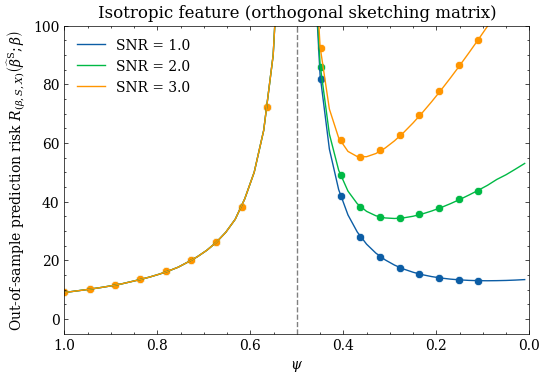

In [17]:
# Plot
with plt.style.context(['science', 'no-latex', 'std-colors']):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))

    snr, emp_psi, emp_risk, psi, risk = load_files('thm4.2_psi_S_orthogonal/alpha3sigma3_nsim500.json')
    ax = sns.scatterplot(x=emp_psi, y=emp_risk)
    ax = sns.lineplot(x=psi, y=risk, label = "SNR = " + str(np.round(snr, 2)))

    snr, emp_psi, emp_risk, psi, risk = load_files('thm4.2_psi_S_orthogonal/alpha6sigma3_nsim500.json')
    ax = sns.scatterplot(x=emp_psi, y=emp_risk)
    ax = sns.lineplot(x=psi, y=risk, label = "SNR = " + str(np.round(snr, 2)))

    snr, emp_psi, emp_risk, psi, risk = load_files('thm4.2_psi_S_orthogonal/alpha9sigma3_nsim500.json')
    ax = sns.scatterplot(x=emp_psi, y=emp_risk)
    ax = sns.lineplot(x=psi, y=risk, label = "SNR = " + str(np.round(snr, 2)))

    ax.set_ylim(-5, 100)
    ax.set_xlim(0, 1)
    ax.axvline(x=0.5, color="grey", linestyle='dashed', linewidth=1)
    ax.set_title("Isotropic feature (orthogonal sketching matrix)")
    ax.invert_xaxis()

    ax.set_ylabel(r"Out-of-sample prediction risk $R_{(\beta, S, X)}\left(\widehat{\beta}^{\mathrm{S}} ; \beta\right)$")
    ax.set_xlabel(r"$\psi$")


#     snr, emp_psi, emp_risk, psi, risk = load_files('thm3.2_fixed_np_S_iid/SNR1.0_nsim500.json')
#     ax[1] = sns.scatterplot(x=emp_psi, y=emp_risk, ax=ax[1])
#     ax[1] = sns.lineplot(x=psi, y=risk, label = "SNR = " + str(np.round(snr, 2)), ax=ax[1])

#     snr, emp_psi, emp_risk, psi, risk = load_files('thm3.2_fixed_np_S_iid/SNR2.0_nsim500.json')
#     ax[1] = sns.scatterplot(x=emp_psi, y=emp_risk, ax=ax[1])
#     ax[1] = sns.lineplot(x=psi, y=risk, label = "SNR = " + str(np.round(snr, 2)), ax=ax[1])

#     snr, emp_psi, emp_risk, psi, risk = load_files('thm3.2_fixed_np_S_iid/SNR3.0_nsim500.json')
#     ax[1] = sns.scatterplot(x=emp_psi, y=emp_risk, ax=ax[1])
#     ax[1] = sns.lineplot(x=psi, y=risk, label = "SNR = " + str(np.round(snr, 2)), ax=ax[1])

#     ax[1].set_ylim(-0.5, 200)
#     ax[1].set_xlim(0, 1)
#     ax[1].axvline(x=0.5, color="grey", linestyle='dashed', linewidth=1)
#     ax[1].set_title("Isotropic feature (i.i.d. sketching matrix)")
#     ax[1].invert_xaxis()

#     ax[1].set_ylabel("Out-of-sample risk")
#     ax[1].set_xlabel(r"$\psi$")

    plt.savefig('figure3.png', dpi=400, facecolor='w', edgecolor='w', pad_inches=None)
    plt.show()

## iid sketching matrix


In [37]:
n_train = 400
n_features = 200
n_test = 100

alpha = 6
sigma = 3
seed = 12341
n_sim = 500

n_pts = 20                 # number of points in the graph for visualizing empirical results (dots)
n_pts_asymp = 50          # number of points in the graph for visualizing theorem 3.2 (line)

In [38]:
%%time
m = np.zeros(n_pts, dtype=int)  # points in the x-axis
mse_emp = np.zeros(n_pts)
psi_range = list(np.linspace(0.11, 0.49, int(n_pts/2))) + list(np.linspace(0.51, 1, int(n_pts/2)))

for i, psi in enumerate(psi_range):
    ppp = int(n_features / 2)
    m[i] = int(n_train * psi) 

    sigma_x = np.diag(lambda_op)

    mse_oos = []
    mse_oos = Parallel(n_jobs=-1)(delayed(simulate_sketching)(n_train, n_features, m[i], alpha, sigma, sigma_x, seed+j, is_orthogonal=False, n_test=n_test) for j in range(n_sim))
    mse_emp[i] = np.mean(mse_oos)
    print(psi, mse_emp[i])

0.11 43.84469438592935
0.15222222222222223 40.80292426996497
0.19444444444444445 37.653399943991154
0.2366666666666667 35.520455142044895
0.2788888888888889 34.421230323167876
0.3211111111111111 35.19485928200913
0.36333333333333334 39.144948356980386
0.40555555555555556 50.57113981266857
0.4477777777777778 88.42624698559425
0.49 603.861818133759
0.51 576.9187374260953
0.5644444444444444 83.5786551892424
0.6188888888888889 48.95863654858021
0.6733333333333333 35.90184750144541
0.7277777777777777 29.235136341181786
0.7822222222222222 25.482046331940058
0.8366666666666667 22.77953709326721
0.8911111111111111 20.7177010247559
0.9455555555555555 19.224187281900246
1.0 18.130058214712953
CPU times: user 29.6 s, sys: 1.3 s, total: 30.9 s
Wall time: 30.9 s


In [39]:
mm = np.zeros(n_pts_asymp, dtype=int)
mse_asy = np.zeros(n_pts_asymp)

psi = list(np.linspace(0.01, 0.49, int(n_pts_asymp/2))) + list(np.linspace(0.51, 1, int(n_pts_asymp/2)))
for i, ppsi in enumerate(psi):
    mm[i] = int(ppsi * n_train)
    lambda_op = list(np.ones(ppp) * 2) + list(np.ones(ppp) * 1) 

    mse_asy[i] = asy_risk_sketching(n_train, n_features, mm[i], alpha, False, lambda_op, sigma=sigma)

In [ ]:
import os
import json

data = {
    "s_orthogonal": 0,
    "n_train": n_train,
    "alpha": alpha,
    "sigma": sigma,
    "seed": seed,
    "emp_psi": psi_range,
    "emp_sketch_risk": mse_emp.tolist(),
    "psi": psi,
    "sketch_risk": mse_asy.tolist()
}

save_path = "../result/thm4.2_psi_S_iid/" 
if not os.path.isdir(save_path):
    os.makedirs(save_path)

# Save
with open(save_path + 'alpha' + str(alpha) + 'sigma' + str(sigma) + '_nsim' + str(n_sim) + '.json', 'w') as file:
    json.dump(data, file,indent=4)

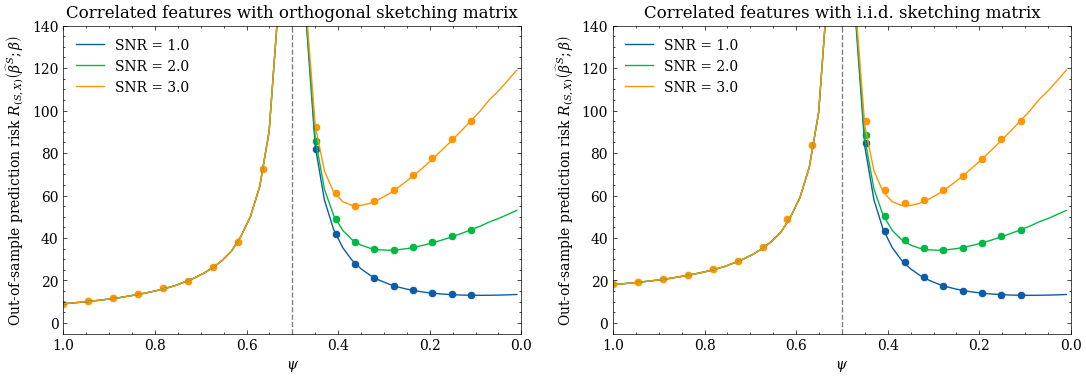

In [10]:
# Plot
with plt.style.context(['science', 'no-latex', 'std-colors']):
    fig, ax = plt.subplots(1, 2, figsize=(13, 4))

    snr, emp_psi, emp_risk, psi, risk = load_files('thm4.2_psi_S_orthogonal/alpha3sigma3_nsim500.json')
    ax[0] = sns.scatterplot(x=emp_psi, y=emp_risk, ax=ax[0])
    ax[0] = sns.lineplot(x=psi, y=risk, label = "SNR = " + str(np.round(snr, 2)), ax=ax[0])

    snr, emp_psi, emp_risk, psi, risk = load_files('thm4.2_psi_S_orthogonal/alpha6sigma3_nsim500.json')
    ax[0] = sns.scatterplot(x=emp_psi, y=emp_risk, ax=ax[0])
    ax[0] = sns.lineplot(x=psi, y=risk, label = "SNR = " + str(np.round(snr, 2)), ax=ax[0])

    snr, emp_psi, emp_risk, psi, risk = load_files('thm4.2_psi_S_orthogonal/alpha9sigma3_nsim500.json')
    ax[0] = sns.scatterplot(x=emp_psi, y=emp_risk, ax=ax[0])
    ax[0] = sns.lineplot(x=psi, y=risk, label = "SNR = " + str(np.round(snr, 2)), ax=ax[0])

    ax[0].set_ylim(-5, 140)
    ax[0].set_xlim(0, 1)
    ax[0].axvline(x=0.5, color="grey", linestyle='dashed', linewidth=1)
    ax[0].set_title("Correlated features with orthogonal sketching matrix")
    ax[0].invert_xaxis()

    ax[0].set_ylabel(r"Out-of-sample prediction risk $R_{(S, X)}\left(\widehat{\beta}^S ; \beta\right)$")
    ax[0].set_xlabel(r"$\psi$")


    snr, emp_psi, emp_risk, psi, risk = load_files('thm4.2_psi_S_iid/alpha3sigma3_nsim500.json')
    ax[1] = sns.scatterplot(x=emp_psi, y=emp_risk, ax=ax[1])
    ax[1] = sns.lineplot(x=psi, y=risk, label = "SNR = " + str(np.round(snr, 2)), ax=ax[1])

    snr, emp_psi, emp_risk, psi, risk = load_files('thm4.2_psi_S_iid/alpha6sigma3_nsim500.json')
    ax[1] = sns.scatterplot(x=emp_psi, y=emp_risk, ax=ax[1])
    ax[1] = sns.lineplot(x=psi, y=risk, label = "SNR = " + str(np.round(snr, 2)), ax=ax[1])

    snr, emp_psi, emp_risk, psi, risk = load_files('thm4.2_psi_S_iid/alpha9sigma3_nsim500.json')
    ax[1] = sns.scatterplot(x=emp_psi, y=emp_risk, ax=ax[1])
    ax[1] = sns.lineplot(x=psi, y=risk, label = "SNR = " + str(np.round(snr, 2)), ax=ax[1])

    ax[1].set_ylim(-5, 140)
    ax[1].set_xlim(0, 1)
    ax[1].axvline(x=0.5, color="grey", linestyle='dashed', linewidth=1)
    ax[1].set_title("Correlated features with i.i.d. sketching matrix")
    ax[1].invert_xaxis()

    ax[1].set_ylabel(r"Out-of-sample prediction risk $R_{(S, X)}\left(\widehat{\beta}^S ; \beta\right)$")
    ax[1].set_xlabel(r"$\psi$")

    plt.savefig('figure3.png', dpi=400, facecolor='w', edgecolor='w', pad_inches=None)
    plt.show()

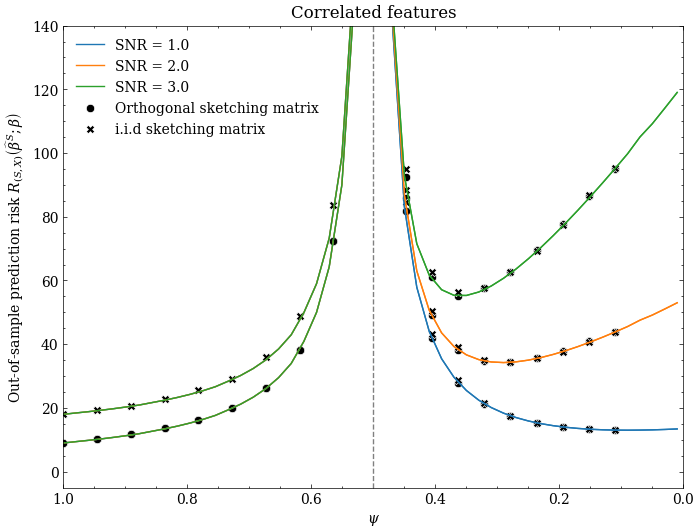

In [39]:
# Plot
with plt.style.context(['science', 'no-latex', 'std-colors']):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    snr, emp_psi, emp_risk, psi, risk = load_files('thm4.2_psi_S_orthogonal/alpha3sigma3_nsim500.json')
    ax = sns.scatterplot(x=emp_psi, y=emp_risk, color='black')
    ax = sns.lineplot(x=psi, y=risk, color='#1f77b4', label = "SNR = " + str(np.round(snr, 2)))

    snr, emp_psi, emp_risk, psi, risk = load_files('thm4.2_psi_S_orthogonal/alpha6sigma3_nsim500.json')
    ax = sns.scatterplot(x=emp_psi, y=emp_risk, color='black')
    ax = sns.lineplot(x=psi, y=risk, color='#ff7f0e', label = "SNR = " + str(np.round(snr, 2)))

    snr, emp_psi, emp_risk, psi, risk = load_files('thm4.2_psi_S_orthogonal/alpha9sigma3_nsim500.json')
    
    ax = sns.lineplot(x=psi, y=risk, color='#2ca02c', label = "SNR = " + str(np.round(snr, 2)))
    ax = sns.scatterplot(x=emp_psi, y=emp_risk, label = "Orthogonal sketching matrix", color='black')

    ax.set_ylim(-5, 140)
    ax.set_xlim(0, 1)
    ax.axvline(x=0.5, color="grey", linestyle='dashed', linewidth=1)
    ax.set_title("Correlated features")
    ax.invert_xaxis()

    ax.set_ylabel(r"Out-of-sample prediction risk $R_{(S, X)}\left(\widehat{\beta}^S ; \beta\right)$")
    ax.set_xlabel(r"$\psi$")


    snr, emp_psi, emp_risk, psi, risk = load_files('thm4.2_psi_S_iid/alpha3sigma3_nsim500.json')
    ax = sns.scatterplot(x=emp_psi, y=emp_risk, marker = 'X', color='black')
    ax = sns.lineplot(x=psi, y=risk, color='#1f77b4')

    snr, emp_psi, emp_risk, psi, risk = load_files('thm4.2_psi_S_iid/alpha6sigma3_nsim500.json')
    ax = sns.scatterplot(x=emp_psi, y=emp_risk, marker = 'X', color='black')
    ax = sns.lineplot(x=psi, y=risk, color='#ff7f0e')

    snr, emp_psi, emp_risk, psi, risk = load_files('thm4.2_psi_S_iid/alpha9sigma3_nsim500.json')
    ax = sns.scatterplot(x=emp_psi, y=emp_risk, marker = 'X', label = "i.i.d sketching matrix", color='black')
    ax = sns.lineplot(x=psi, y=risk, color='#2ca02c')

    plt.savefig('figure3.png', dpi=400, facecolor='w', edgecolor='w', pad_inches=None)
    plt.show()

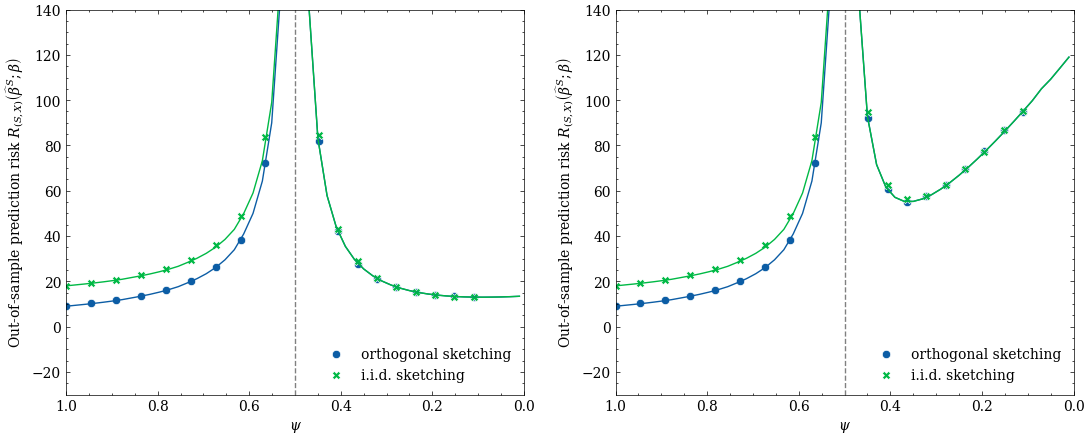

In [5]:
# Plot
with plt.style.context(['science', 'no-latex', 'std-colors']):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))

    snr, emp_psi, emp_risk, psi, risk = load_files('thm4.2_psi_S_orthogonal/alpha3sigma3_nsim500.json')
    ax[0] = sns.scatterplot(x=emp_psi, y=emp_risk, label = "orthogonal sketching", ax=ax[0])
    ax[0] = sns.lineplot(x=psi, y=risk, ax=ax[0])
    
    snr, emp_psi, emp_risk, psi, risk = load_files('thm4.2_psi_S_iid/alpha3sigma3_nsim500.json')
    ax[0] = sns.scatterplot(x=emp_psi, y=emp_risk, marker = 'X', label = "i.i.d. sketching", ax=ax[0])
    ax[0] = sns.lineplot(x=psi, y=risk, ax=ax[0])
    
    ax[0].set_ylim(-30, 140)
    ax[0].set_xlim(0, 1)
    ax[0].axvline(x=0.5, color="grey", linestyle='dashed', linewidth=1)
    #ax[0].set_title("Correlated features, SNR = 1.0")
    ax[0].invert_xaxis()
    ax[0].legend(loc='lower right')
    ax[0].set_ylabel(r"Out-of-sample prediction risk $R_{(S, X)}\left(\widehat{\beta}^S ; \beta\right)$")
    ax[0].set_xlabel(r"$\psi$")
    
    snr, emp_psi, emp_risk, psi, risk = load_files('thm4.2_psi_S_orthogonal/alpha9sigma3_nsim500.json')
    ax[1] = sns.scatterplot(x=emp_psi, y=emp_risk, label = "orthogonal sketching", ax=ax[1])
    ax[1] = sns.lineplot(x=psi, y=risk, ax=ax[1])

    snr, emp_psi, emp_risk, psi, risk = load_files('thm4.2_psi_S_iid/alpha9sigma3_nsim500.json')
    ax[1] = sns.scatterplot(x=emp_psi, y=emp_risk, marker = 'X', label = "i.i.d. sketching", ax=ax[1])
    ax[1] = sns.lineplot(x=psi, y=risk, ax=ax[1])

    ax[1].set_ylim(-30, 140)
    ax[1].set_xlim(0, 1)
    ax[1].axvline(x=0.5, color="grey", linestyle='dashed', linewidth=1)
    #ax[1].set_title("Correlated features, SNR = 3.0")
    ax[1].invert_xaxis()
    ax[1].legend(loc='lower right')
    ax[1].set_ylabel(r"Out-of-sample prediction risk $R_{(S, X)}\left(\widehat{\beta}^S ; \beta\right)$")
    ax[1].set_xlabel(r"$\psi$")

    plt.savefig('figure3.pdf', dpi=400, facecolor='w', edgecolor='w', pad_inches=None)
    plt.show()

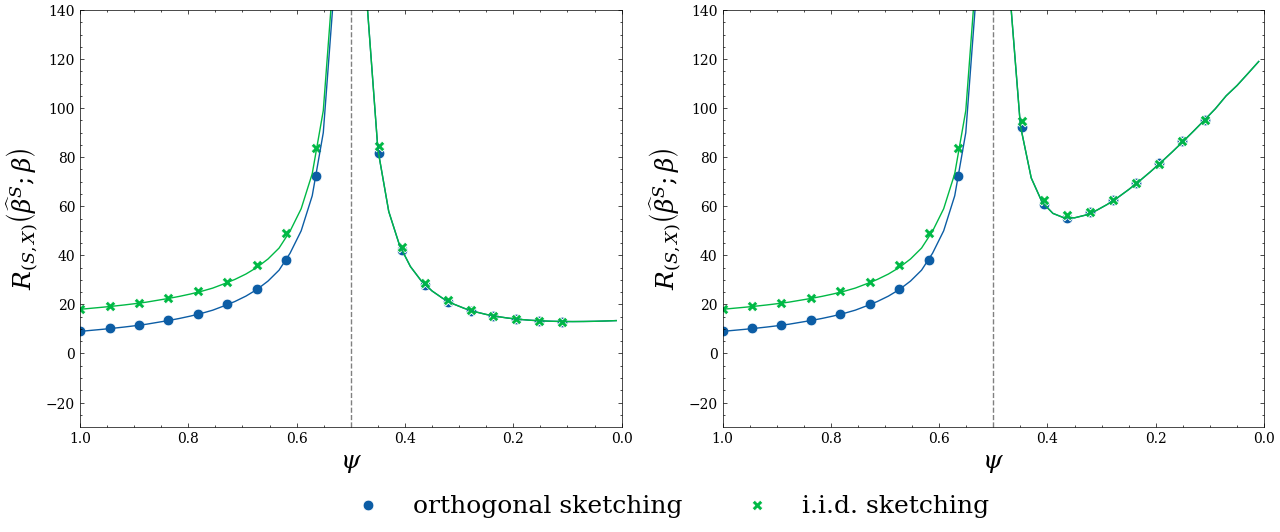

In [6]:
# Plot
with plt.style.context(['science', 'no-latex', 'std-colors']):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))

    snr, emp_psi, emp_risk, psi, risk = load_files('thm4.2_psi_S_orthogonal/alpha3sigma3_nsim500.json')
    ax[0] = sns.scatterplot(x=emp_psi, y=emp_risk,  s=60, label = "orthogonal sketching", ax=ax[0])
    ax[0] = sns.lineplot(x=psi, y=risk, ax=ax[0])
    
    snr, emp_psi, emp_risk, psi, risk = load_files('thm4.2_psi_S_iid/alpha3sigma3_nsim500.json')
    ax[0] = sns.scatterplot(x=emp_psi, y=emp_risk,  s=60, marker = 'X', label = "i.i.d. sketching", ax=ax[0])
    ax[0] = sns.lineplot(x=psi, y=risk, ax=ax[0])
    
    ax[0].set_ylim(-30, 140)
    ax[0].set_xlim(0, 1)
    ax[0].axvline(x=0.5, color="grey", linestyle='dashed', linewidth=1)
    #ax[0].set_title("Correlated features, SNR = 1.0")
    ax[0].invert_xaxis()
    ax[0].legend(loc='lower right')
    ax[0].set_ylabel(r"$R_{(S, X)}\left(\widehat{\beta}^S ; \beta\right)$", fontsize=18)
    ax[0].set_xlabel(r"$\psi$", fontsize=18)
    
    snr, emp_psi, emp_risk, psi, risk = load_files('thm4.2_psi_S_orthogonal/alpha9sigma3_nsim500.json')
    ax[1] = sns.scatterplot(x=emp_psi, y=emp_risk,  s=60, label = "orthogonal sketching", ax=ax[1])
    ax[1] = sns.lineplot(x=psi, y=risk, ax=ax[1])

    snr, emp_psi, emp_risk, psi, risk = load_files('thm4.2_psi_S_iid/alpha9sigma3_nsim500.json')
    ax[1] = sns.scatterplot(x=emp_psi, y=emp_risk, marker = 'X', s=60, label = "i.i.d. sketching", ax=ax[1])
    ax[1] = sns.lineplot(x=psi, y=risk, ax=ax[1])

    ax[1].set_ylim(-30, 140)
    ax[1].set_xlim(0, 1)
    ax[1].axvline(x=0.5, color="grey", linestyle='dashed', linewidth=1)
    #ax[1].set_title("Correlated features, SNR = 3.0")
    ax[1].invert_xaxis()
    ax[1].legend(loc='lower right')
    ax[1].set_ylabel(r"$R_{(S, X)}\left(\widehat{\beta}^S ; \beta\right)$", fontsize=18)
    ax[1].set_xlabel(r"$\psi$", fontsize=18)

    ax[0].get_legend().remove()
    ax[1].get_legend().remove()

    handles, labels = ax[0].get_legend_handles_labels()
 
    #handles, labels = ax[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.52, -0.1), ncol = 3, prop={'size':18})
    plt.tight_layout()

    plt.savefig('figure3.pdf', dpi=400, facecolor='w', edgecolor='w', pad_inches=None)
    plt.show()